<a href="https://colab.research.google.com/github/mo1022/aidemy_blog/blob/main/epl_2020_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [96]:
# Lord English Premier League Statistics of 2020/2021 season.
target_directory = './drive/MyDrive/Colab Notebooks/blog/'
# game_data_file = target_directory + 'epl_games_2019_2020.csv'
# player_data_file = target_directory + 'epl_players_2019_2020.csv'
player_data_file = target_directory + 'epl_players_2019_2020_classified.csv'


In [97]:
# # 試合データ
# game_data = pd.read_csv(game_data_file)
# # Lord English Premier League Game Statistics of 2019/2020 Season. [576 rows x 45 columns]
# print(game_data)
# # 試合データ - 特徴量の出力
# print(game_data.columns.values)

In [98]:
team_colors = {'Arsenal':'#ef0107', 'Aston Villa':'#95bfe5', 'Bournemouth':'#da291c', 'Brighton':'#0057b8',
               'Burnley':'#6c1d45', 'Chelsea':'#034694', 'Crystal Palace':'#1b458f', 'Everton':'#003399',
               'Leicester':'#003090', 'Liverpool':'#c8102e', 'Man City':'#6cabdd', 'Man Utd':'#da291c',
               'Newcastle United':'#241f20', 'Norwich':'#fff200', 'Sheffield United':'#ee2737', 
               'Southampton':'#d71920', 'Tottenham':'#132257', 'Watford':'#fbee23', 'West Ham':'#7a263a',
               'Wolves':'#fdb913'}

In [99]:
# 選手データ(選手のゲーム別成績)
player_data = pd.read_csv(player_data_file)
# Lord English Premier League Player Statistics of 2019/2020 Season. [22502 rows x 35 columns]
# print(player_data)
# 選手データ - 特徴量の出力
print(player_data.columns.values)
# チーム一覧 A->Z
print(sorted(player_data.team.unique()))


['Unnamed: 0' 'assists' 'bonus' 'bps' 'clean_sheets' 'creativity'
 'element' 'fixture' 'goals_conceded' 'goals_scored' 'ict_index'
 'influence' 'kickoff_time' 'minutes' 'opponent_team' 'own_goals'
 'penalties_missed' 'penalties_saved' 'red_cards' 'round' 'saves'
 'selected' 'team_a_score' 'team_h_score' 'threat' 'total_points'
 'transfers_balance' 'transfers_in' 'transfers_out' 'value' 'was_home'
 'yellow_cards' 'full' 'team' 'ppm' 'class']
['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool', 'Man City', 'Man Utd', 'Newcastle United', 'Norwich', 'Sheffield United', 'Southampton', 'Tottenham', 'Watford', 'West Ham', 'Wolves']


In [100]:
# 欠損値の確認 -> 欠損値なし
print(player_data.isnull().sum())

Unnamed: 0           0
assists              0
bonus                0
bps                  0
clean_sheets         0
creativity           0
element              0
fixture              0
goals_conceded       0
goals_scored         0
ict_index            0
influence            0
kickoff_time         0
minutes              0
opponent_team        0
own_goals            0
penalties_missed     0
penalties_saved      0
red_cards            0
round                0
saves                0
selected             0
team_a_score         0
team_h_score         0
threat               0
total_points         0
transfers_balance    0
transfers_in         0
transfers_out        0
value                0
was_home             0
yellow_cards         0
full                 0
team                 0
ppm                  0
class                0
dtype: int64


In [101]:
# チームの絞り込み LiverpoolとManchesterCityの2チームに限定
player_data = player_data[player_data.team.isin(['Liverpool', 'Man City'])]

In [102]:
# 選手名リスト作成
players = player_data.full.unique()
# アルファベット順の上位10名と下位10名を表示
print(players[1:10])
print(players[-10:-1])

['Adri?n San Miguel del Castillo' 'Alex Oxlade-Chamberlain'
 'Alisson Ramses Becker' 'Andrew Robertson' 'Andy Lonergan'
 'Aymeric Laporte' 'Benjamin Mendy'
 'Bernardo Mota Veiga de Carvalho e Silva' 'Caoimhin Kelleher']
['Sadio Man?' 'Scott Carson' 'Sergio Ag?ero' 'Simon Mignolet'
 'Takumi Minamino' 'Taylor Harwood-Bellis' 'Tommy Doyle'
 'Trent Alexander-Arnold' 'Virgil van Dijk']


In [113]:
# 選手名の補正 文字化けしている文字を置換する。
updated_names = {}
for player in players:
    split_name = player.split(' ')
    updated_names[player] = split_name[0][0] + '. ' + split_name[-1]

# Update certain player names
updated_names['Sergio Ag?ero'] = 'S. Agüero'
updated_names['Sadio Man?'] = 'S. Mané'
updated_names['Ra?l Jim?nez'] = 'R. Jiménez'
updated_names['Nicolas P?p?'] = 'N. Pépé'
updated_names['Emiliano Buend?a'] = 'E. Buendía'
updated_names['Adama Traor?'] = 'A. Traoré'
updated_names['Pascal Gro?'] = 'P. Groß'
updated_names['Rui Pedro dos Santos Patr?cio'] = 'R. Patrício'
updated_names['Ilkay G?ndogan'] = 'I. Gündoğan'

In [104]:
# 90分あたりのゴール数＋アシスト数(攻撃的特徴量)
player_goals_and_assists = {}
# 90分あたりの失点数(守備的特徴量)
player_goals_conceded = {}
for player in players:
  mins = player_data[player_data['full'] == player].minutes.sum() / 90.
  if mins >= 10:
    player_goals_and_assists[player] = (player_data[player_data['full'] == player].goals_scored.sum() / mins) + (player_data[player_data['full'] == player].assists.sum() / mins)
    player_goals_conceded[player] = player_data[player_data['full'] == player].goals_conceded.sum() / mins

In [105]:
# 90分あたりのゴール数＋アシスト数(攻撃的特徴量) 上位20名
top20_players_goals_and_assists = sorted(player_goals_and_assists.keys(), key=player_goals_and_assists.get, reverse=True)[:20]
print(top20_players_goals_and_assists)

['Sergio Ag?ero', 'Riyad Mahrez', 'Kevin De Bruyne', 'Gabriel Fernando de Jesus', 'Sadio Man?', 'Mohamed Salah', 'David Silva', 'Raheem Sterling', 'Bernardo Mota Veiga de Carvalho e Silva', 'Roberto Firmino', 'Trent Alexander-Arnold', 'Andrew Robertson', 'James Milner', 'Jordan Henderson', 'Alex Oxlade-Chamberlain', 'Fabio Henrique Tavares', 'Kyle Walker', 'Virgil van Dijk', 'Rodrigo Hernandez', 'Nicol?s Otamendi']


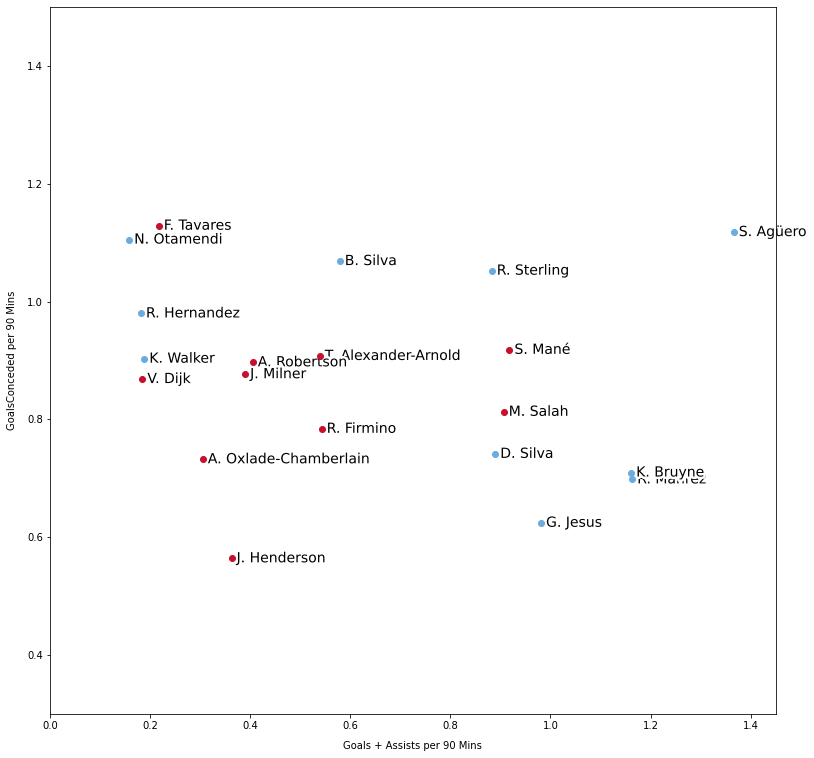

In [106]:
# Create Figure Offensive
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)

# Plot player data
for player in top20_players_goals_and_assists:
    team = player_data[player_data['full'] == player].team.iloc[0]
    ax.plot(player_goals_and_assists[player], player_goals_conceded[player], 'o', color=team_colors[team], zorder=3)
    text = ax.text(player_goals_and_assists[player] + 0.01, player_goals_conceded[player], updated_names[player], size=14, va='center', ha='left', zorder=2)
    text.set_path_effects([pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])

# Add grid
ax.grid(color='white', linewidth=2)

# Axis labels
ax.set_xlabel('Goals + Assists per 90 Mins', labelpad=10)
ax.set_ylabel('GoalsConceded per 90 Mins', labelpad=10)

# Axis limits
ax.set_xlim(0.0, 1.45)
ax.set_ylim(0.3, 1.5)

plt.show()

In [107]:
# 90分あたりの失点数(守備的特徴量) 上位40名
top_players_goals_conceded = sorted(player_goals_conceded.keys(), key=player_goals_conceded.get, reverse=False)[:40]
print(top_players_goals_conceded)

['Aymeric Laporte', 'Jordan Henderson', 'Gabriel Fernando de Jesus', 'Riyad Mahrez', 'Kevin De Bruyne', 'Joseph Gomez', 'Alex Oxlade-Chamberlain', 'David Silva', 'Roberto Firmino', 'Benjamin Mendy', 'Mohamed Salah', 'Jo?o Pedro Cavaco Cancelo', 'Alisson Ramses Becker', 'Georginio Wijnaldum', 'Virgil van Dijk', 'James Milner', 'Andrew Robertson', 'Kyle Walker', 'Trent Alexander-Arnold', 'Ederson Santana de Moraes', 'Sadio Man?', 'Rodrigo Hernandez', 'Fernando Luiz Rosa', 'Raheem Sterling', 'Oleksandr Zinchenko', 'Bernardo Mota Veiga de Carvalho e Silva', 'Nicol?s Otamendi', 'Sergio Ag?ero', 'Fabio Henrique Tavares', 'Ilkay G?ndogan', 'John Stones']


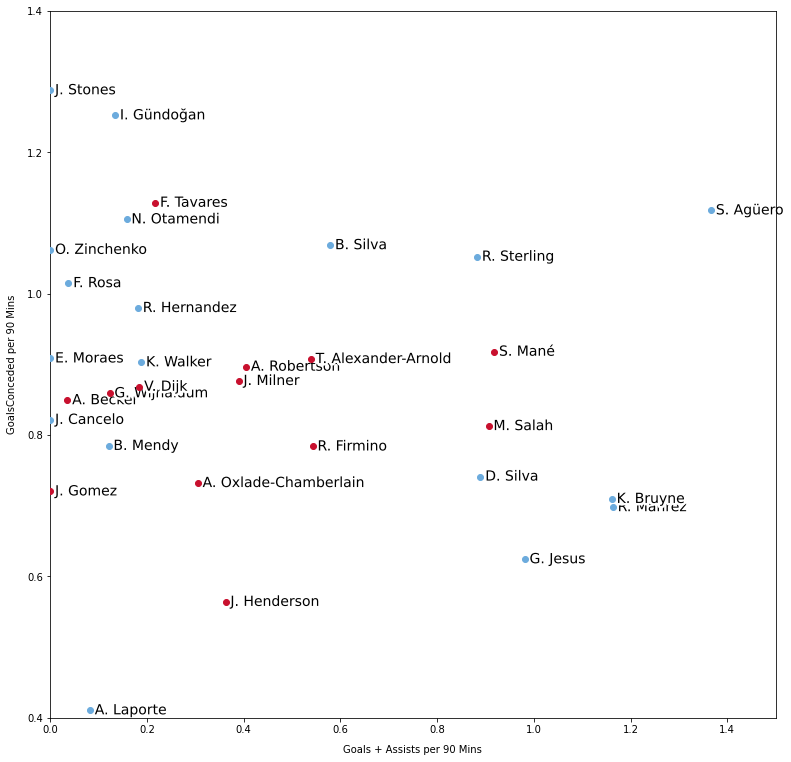

In [114]:
# Create Figure Defensive
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)

# Plot player data
for player in top_players_goals_conceded:
    team = player_data[player_data['full'] == player].team.iloc[0]
    ax.plot(player_goals_and_assists[player], player_goals_conceded[player], 'o', color=team_colors[team], zorder=3)
    text = ax.text(player_goals_and_assists[player] + 0.01, player_goals_conceded[player], updated_names[player], size=14, va='center', ha='left', zorder=2)
    text.set_path_effects([pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])

# Add grid
ax.grid(color='white', linewidth=2)

# Axis labels
ax.set_xlabel('Goals + Assists per 90 Mins', labelpad=10)
ax.set_ylabel('GoalsConceded per 90 Mins', labelpad=10)

# Axis limits
ax.set_xlim(0, 1.5)
ax.set_ylim(0.4, 1.4)

plt.show()

In [148]:
# Refer to https://premium.aidemy.jp/courses/5020/exercises/rkEPkJ3Qm
# 教師あり学習（分類） 1.1.5 データを用意する方法（2）

# playersの1列目(assists), 8列目(goals_conceded), 9列目(goals_scored)を格納
X = player_data.iloc[:, [1, 8, 9]]
# top_players_goals_concededのクラスラベルを格納
y = player_data['class']

print(X)
print(y)

       assists  goals_conceded  goals_scored
321          0               0             0
322          0               0             0
323          0               0             0
324          0               0             0
325          0               0             0
...        ...             ...           ...
22221        0               0             0
22222        0               0             0
22223        0               0             0
22224        0               0             0
22225        0               0             0

[2030 rows x 3 columns]
321      National
322      National
323      National
324      National
325      National
           ...   
22221    National
22222    National
22223    National
22224    National
22225    National
Name: class, Length: 2030, dtype: object


In [150]:
# テストデータとトレーニングデータの分割
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

# ロジスティック回帰
# モデル構築
model = LogisticRegression()
# 学習
model.fit(train_X, train_y)
# 予測
model.predict(test_X)
# 正解率の評価
model.score(test_X, test_y)

0.9211822660098522